In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Data Cleaning and Preprocessing

In [3]:
# Load the dataset

asthma_df = pd.read_csv("data/asthma_disease_data.csv")
df = asthma_df.copy()  

## Handle Identifiers & Irrelevant Features

- `PatientID`: I can drop it because is not useful for prediction

- `DoctorInCharge` - likely an identifier and can be also dropped.

In [5]:
df = df.drop(columns=["PatientID", "DoctorInCharge"])

## Duplicates

In [7]:
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

Duplicate rows: 0


No duplicates found

## Outliers

- Check with boxplots, Z-scores, or IQR.

- Try different handling: keep them, winsorize, or remove.

In [10]:
z_scores = np.abs((df.select_dtypes(include=np.number) - df.mean()) / df.std())
outlier_counts = (z_scores > 3).sum()
print(outlier_counts)

Age                         0
Gender                      0
Ethnicity                   0
EducationLevel              0
BMI                         0
Smoking                     0
PhysicalActivity            0
DietQuality                 0
SleepQuality                0
PollutionExposure           0
PollenExposure              0
DustExposure                0
PetAllergy                  0
FamilyHistoryAsthma         0
HistoryOfAllergies          0
Eczema                      0
HayFever                    0
GastroesophagealReflux      0
LungFunctionFEV1            0
LungFunctionFVC             0
Wheezing                    0
ShortnessOfBreath           0
ChestTightness              0
Coughing                    0
NighttimeSymptoms           0
ExerciseInduced             0
Diagnosis                 124
dtype: int64


## Encoding Categorical Variables

Two common strategies:

- Keep 0/1 as-is (binary features).

- One-hot encode multi-class categorical like Ethnicity or EducationLevel.

In [12]:
df_encoded = pd.get_dummies(
    asthma_df,
    columns=["Ethnicity", "EducationLevel"],
    prefix=["Ethnicity", "Education"],
    drop_first=True   # optional: avoid dummy variable trap
)

df_encoded.head()

,PatientID,Age,Gender,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,PollenExposure,...,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge,Ethnicity_1,Ethnicity_2,Ethnicity_3,Education_1,Education_2,Education_3
0,5034,63,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,...,0,1,0,Dr_Confid,True,False,False,False,False,False
1,5035,26,1,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,...,1,1,0,Dr_Confid,False,True,False,False,True,False
2,5036,57,0,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,...,1,1,0,Dr_Confid,False,True,False,True,False,False
3,5037,40,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,7.571845,...,1,0,0,Dr_Confid,False,True,False,True,False,False
4,5038,61,0,19.283802,0,4.604493,3.127048,9.625799,0.980875,3.049807,...,0,1,0,Dr_Confid,False,False,False,False,False,True


## Feature Scaling

I will try **Standardization** vs **Min-Max** scaling for continuous features.

In [14]:
cont_cols = ["Age","BMI","PhysicalActivity","DietQuality","SleepQuality",
             "PollutionExposure","PollenExposure","DustExposure",
             "LungFunctionFEV1","LungFunctionFVC"]

scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

# Standardization
df_std = asthma_df.copy()
df_std[cont_cols] = scaler_std.fit_transform(df_std[cont_cols])

# Min-Max scaling
df_mm = asthma_df.copy()
df_mm[cont_cols] = scaler_mm.fit_transform(df_mm[cont_cols])


## Feature Correlation / Redundancy

Check if some variables are highly correlated (e.g., FEV1 and FVC)

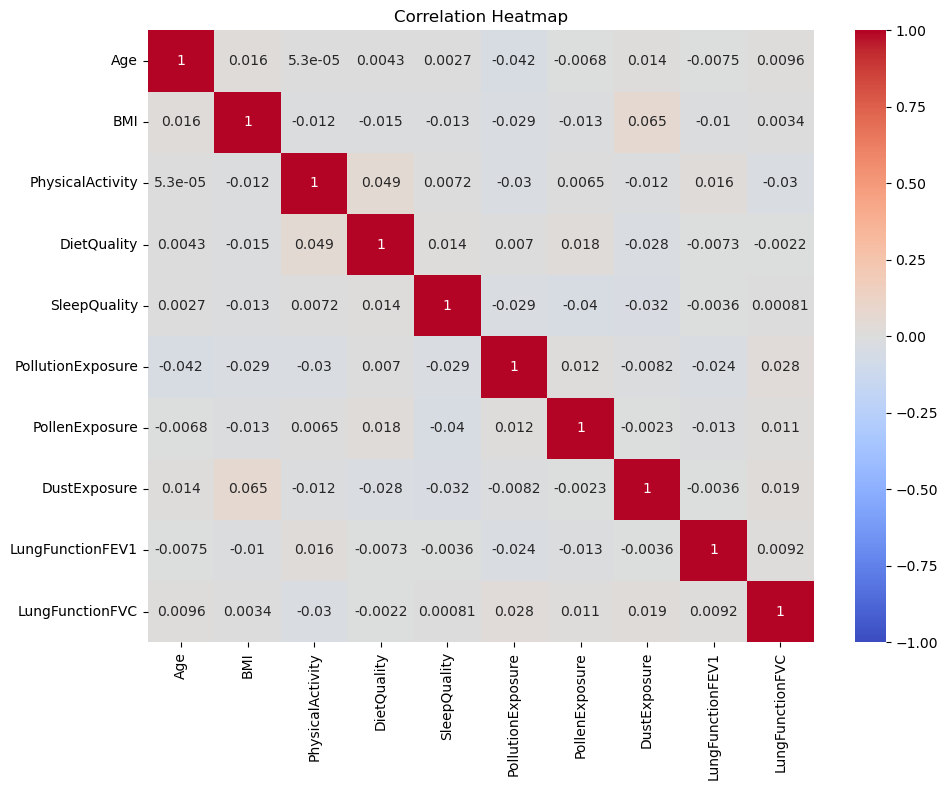

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

cont_cols = ["Age","BMI","PhysicalActivity","DietQuality","SleepQuality",
             "PollutionExposure","PollenExposure","DustExposure",
             "LungFunctionFEV1","LungFunctionFVC"]

corr = asthma_df[cont_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()

# Save the plot
plt.savefig("reports/correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

### Observations from the heatmap

- Overall pattern

Most correlations are very close to 0 (−0.05 to +0.06).

This means the continuous features in your dataset are largely independent of one another. That’s good for modeling → less redundancy, no strong multicollinearity.

**Near-zero correlations**

- Age vs others → all values around 0.0 to 0.02 (basically uncorrelated).

- PhysicalActivity vs BMI = −0.012 → negligible.

- PollutionExposure vs SleepQuality = −0.029 → very weak.

Interpretation: No strong linear relationship between demographics, lifestyle, exposures, and lung function.

**Slightly higher ones**

- BMI vs DustExposure = 0.065

- DietQuality vs PhysicalActivity = 0.049

Both are tiny correlations → practically no real association.

**Lung function measures**

LungFunctionFEV1 vs LungFunctionFVC = 0.009 → in real-world clinical data, these are usually correlated. Here, they appear almost independent, which may indicate:

- Synthetic dataset (values randomly generated).

- Features scaled separately.

**Conclusion**

- No strong correlations → you don’t need to drop or combine continuous features for multicollinearity reasons.

- Each continuous feature provides unique information for the model.

## Train-Test Split

I split the dataset into:

- Training set → used to fit the model (learn weights, parameters).

- Test set → held back until the end, used to evaluate performance.

In [40]:
# Separate features and target
X = df_encoded.drop("Diagnosis", axis=1)
y = df_encoded["Diagnosis"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for testing
    random_state=42,      # for reproducibility
    stratify=y            # keeps same class balance in train & test
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 1913
Test size: 479
